In [10]:
import numpy as np
import pydensecrf.densecrf as dcrf
import cv2
from cv2 import imread
from pydensecrf.utils import unary_from_labels
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from matplotlib.patches import Patch
import numpy as np
import webcolors

%matplotlib inline

In [11]:
def decode(rle_mask):
    mask = rle_mask.split()
    img = np.zeros(256*256, dtype=np.uint8)
    for i, m, in enumerate(mask):
        img[i] = int(m)
    return img.reshape(256,256)


def encode(im):
    pixels = im.flatten()
    return ' '.join(str(x) for x in pixels)

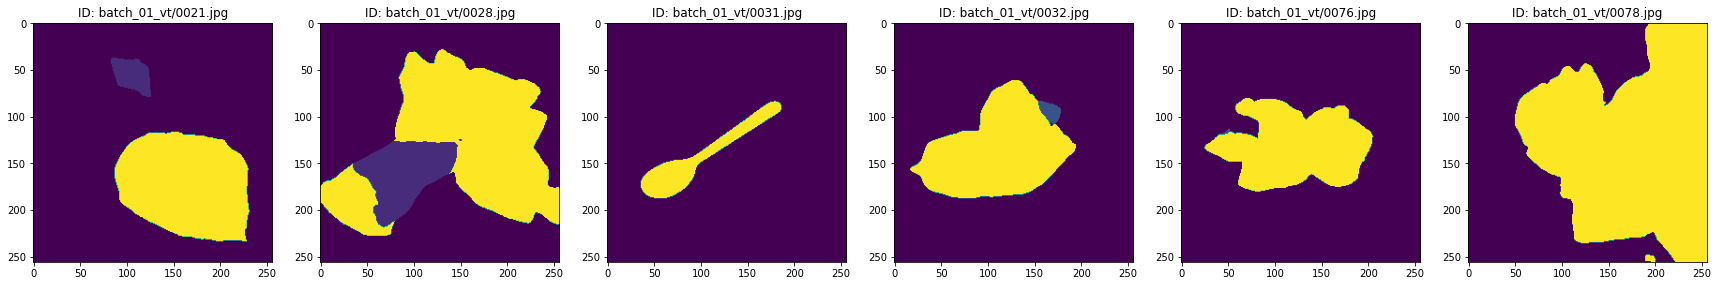

In [12]:
"""
reading and decoding the submission 

"""
df = pd.read_csv('./result/up_swi_VariRGBblurTra.csv')
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'image_id'])
        j = j + 1
        if j>5:
            break
    i = i + 1

In [46]:
def crf(original_image, mask_img):
    
    labels = mask_img.flatten()

    # print(len(labels))
    n_labels = 11
    
    #Setting up the CRF model
    
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3,3), compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(10,10), srgb=(70,70,70), rgbim=original_image, compat=3)

    Q = d.inference(45)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [47]:
test_path = '/opt/ml/segmentation/input/data/'

In [22]:
class_colormap = [[0,0,0],
               [192,0,128],
               [0,128,192],
               [0,128,64],
               [128,0,0],
               [64,0,128],
               [64,0,192],
               [192,128,64],
               [192,192,128],
               [64,64,128],
               [128,0,192]]
CLASSES = ("Backgroud", "General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (r, g, b) in enumerate(class_colormap):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

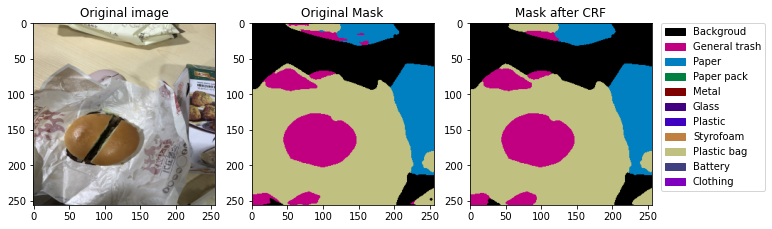

In [52]:
"""
visualizing the effect of applying CRF

"""
nImgs = 1
i = 8
j = 1
plt.figure(figsize=(15,5*nImgs))

plt.subplots_adjust(wspace=0.2,hspace=0.1)  #adjust this to change vertical and horiz. spacings..
category_and_rgb = [[CLASSES[idx], (r,g,b)] for idx, (r, g, b) in enumerate(class_colormap)]
legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                            edgecolor=webcolors.rgb_to_hex(rgb), 
                            label=category) for category, rgb in category_and_rgb]
while True:
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])        
        orig_img = imread(test_path+df.loc[i,'image_id'])
        orig_img = cv2.resize(orig_img, (256, 256))
        #Applying CRF on FCN-16 annotated image
        crf_output = crf(orig_img,decoded_mask)
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        plt.title('Original image')
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(label_to_color_image(decoded_mask))        
        plt.title('Original Mask')
        plt.subplot(nImgs,4,4*j-1)
        plt.imshow(label_to_color_image(crf_output)) 
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.title('Mask after CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1

In [7]:
"""
Applying CRF on the predicted mask 

"""
for i in tqdm(range(df.shape[0])):
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])        
        orig_img = imread(test_path+df.loc[i,'image_id'])
        orig_img = cv2.resize(orig_img, (256, 256))
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'PredictionString'] = encode(crf_output)

 39%|███▉      | 319/819 [05:36<08:47,  1.06s/it]


KeyboardInterrupt: 

In [ ]:
df.to_csv('crf_correction.csv',index=False)